In [1]:
# pip install matplotlib
# pip install scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [20]:
def sample_exponential(l):
    u = np.random.random()
    d_t = -np.log(1-u) / l
    return d_t

class population:
    # beta is infection rate while gamma is recover rate. 
    def __init__(self, _n, _i, _inf_propensity, _rec_propensity, _r=0):
        self.n = _n
        self.i = _i
        self.r = _r
        self.s = self.n - self.i - self.r
        # propensity is constant
        # infection propensity:
        self.INF_P = _inf_propensity
        # recover propensity:
        self.REC_P = _rec_propensity
        self.total_transition_rate = (self.INF_P * self.i / self.n * self.s + self.REC_P * self.i)
    
    def update_state(self, event:str):
        if( event == 'infected'):
            self.s -= 1
            self.i += 1
        elif( event == 'recovered'):
            self.i -= 1
            self.r += 1
        else:
            raise Exception("No such event.")
        self.total_transition_rate = (self.INF_P * self.i * self.s + self.REC_P * self.i)
        
    def update_states(self, eventNum:int, event:str):
        if( event == 'infected'):
            if(eventNum > self.s):
                eventNum = self.s
            self.s -= eventNum
            self.i += eventNum
        elif( event == 'recovered'):
            if(eventNum > self.i):
                eventNum = self.i
            self.i -= eventNum
            self.r += eventNum
        else:
            raise Exception("No such event.")
        self.total_transition_rate = (self.INF_P * self.i * self.s + self.REC_P * self.i)

    def sample_individual(self):
        u = np.random.random()
        if( u <= ( self.REC_P * self.i / self.total_transition_rate)):
            return "recovered"
        else:
            return "infected"
import copy
def simulate_SIR_gillespie (po:population, cycles : int,steps:int, X, S, I, R):
    current_cycle = 0
    
    while ( current_cycle < cycles):
        _p = copy.deepcopy(po)
        current_step = 0
        while (current_step < steps):
            # choose which type of events happened. 
            event = _p.sample_individual()
            # update population state
            _p.update_state(event)

            # if the exponential distribution of the time is nearly flat, it means it would take super long time 
            # for next event to happen. Then we just stop our simulation.
            if(_p.total_transition_rate <= 1.0e-4):
                X[current_cycle, current_step + 1:] = X[current_cycle, current_step]
                S[current_cycle, current_step + 1:] = S[current_cycle, current_step]
                I[current_cycle, current_step + 1:] = I[current_cycle, current_step]
                R[current_cycle, current_step + 1:] = R[current_cycle, current_step]
                break
            # How long time does this type of event happen take? 
            d_t = sample_exponential(_p.total_transition_rate)

            # print(f'===== The {current_step} iteration is a {event} event after time {d_t}.===== ')
            # print(vars(_p))

            # Take a record after a single conversion event. 
            X[current_cycle, current_step + 1] = X[current_cycle, current_step] + d_t
            S[current_cycle, current_step + 1] = _p.s
            I[current_cycle, current_step + 1] = _p.i
            R[current_cycle, current_step + 1] = _p.r
            current_step += 1
        current_cycle +=1

def simulate_SIR_tau_leaping (po:population, cycles:int, steps:int, tau, X, S, I, R):
    current_cycle = 0
    while ( current_cycle < cycles):
        _p = copy.deepcopy(po)
        current_step = 0
        while (current_step < steps):
            # Set how many times each event happens in givel tau time. 
            ni = poisson.ppf(np.random.random(), _p.INF_P * _p.i * _p.s * tau)
            nr = poisson.ppf(np.random.random(), _p.REC_P * _p.i * tau)
            # update population state
            _p.update_states(ni, "infected")
            _p.update_states(nr, "recovered")

            # if the exponential distribution of the time is nearly flat, it means it would take super long time 
            # for next event to happen. Then we just stop our simulation.
            if(_p.total_transition_rate <= 1.0e-4):
                X[current_cycle, current_step + 1:] = X[current_cycle, current_step]
                S[current_cycle, current_step + 1:] = S[current_cycle, current_step]
                I[current_cycle, current_step + 1:] = I[current_cycle, current_step]
                R[current_cycle, current_step + 1:] = R[current_cycle, current_step]
                break

            # Take a record after a single conversion event. 
            X[current_cycle, current_step + 1] = X[current_cycle, current_step] + tau
            S[current_cycle, current_step + 1] = _p.s
            I[current_cycle, current_step + 1] = _p.i
            R[current_cycle, current_step + 1] = _p.r
            current_step += 1
        current_cycle +=1

def simulate_SIR_hybrid()
    pass

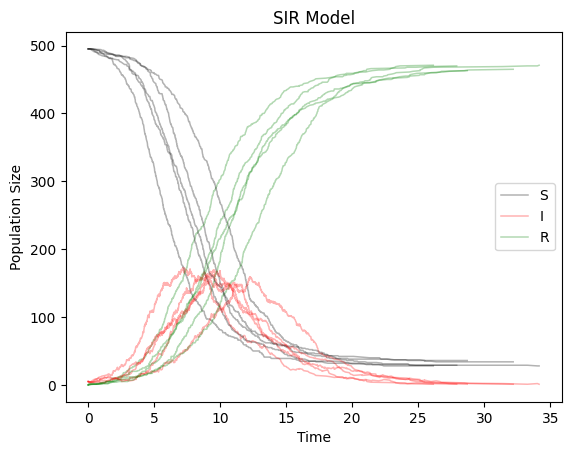

R infinity for Gillespie on average is 468.0. 


In [21]:
# Set repetition cycles and each simulation steps. 
cycles = 5
steps = 1200

# Set record tables. 
po = population(500, 5, 1.0/500.0, 1./3.)
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po.r

simulate_SIR_gillespie(po, cycles, steps, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model")
plt.show()

print(f'R infinity for Gillespie on average is {np.average(R[:, -1])}. ')

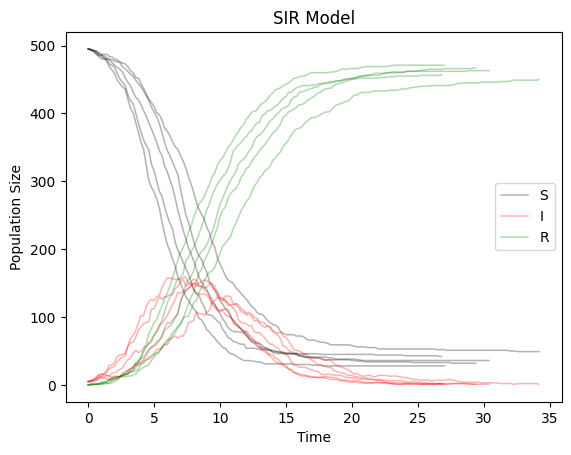

R infinity for tau leaping on average is 461.6. 


In [22]:
# Set repetition cycles and each simulation steps. 
cycles = 5
steps = 1200

# Set record tables. 
po = population(500, 5, 1.0/500.0, 1./3.)
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po.r

simulate_SIR_tau_leaping(po, cycles, steps, 0.2, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model")
plt.show()

print(f'R infinity for tau leaping on average is {np.average(R[:, -1])}. ')